In [1]:
import zipfile
import os
zip_file = '/content/pcos detection.v1i.coco.zip'

unzip_dir = '/content/FRCNN_pcos'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

os.listdir(unzip_dir)

['test', 'valid', 'README.dataset.txt', 'train', 'README.roboflow.txt']

In [2]:
for root, dirs, files in os.walk('/content/FRCNN_pcos'):
    level = root.replace('/content/FRCNN_pcos', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for f in files:
        print(f'{subindent}{f}')


FRCNN_pcos/
  README.dataset.txt
  README.roboflow.txt
  test/
    img_0_5220_jpg.rf.dbdaf606fd0ceeacadd6dea89f6de6d1.jpg
    img_0_8107_jpg.rf.5a4f32e6cd1efc21cf30b7f12b34b2a9.jpg
    img_0_4749_jpg.rf.e60c1dd5aa9550641daa1cb98fc87786.jpg
    img_0_4704_jpg.rf.137aeafdc6a773f750c8986106471b8c.jpg
    img_0_8040_jpg.rf.66755b16d2ea6739dbbf385b73c3c1a3.jpg
    img_0_7738_jpg.rf.6a627834bcff6f05e695234afa342ce9.jpg
    img_0_5240_jpg.rf.87223a003f927929e28428d838266828.jpg
    img_0_4392_jpg.rf.39ea20453613871d72f7c81687c8befe.jpg
    img_0_7176_jpg.rf.af0dc15b0a3c8a261cd280790ca249fc.jpg
    img_0_5304_jpg.rf.01616739cc779db014580b59a12ed80c.jpg
    img_0_5427_jpg.rf.44d38ce368a49f5f1e362861357ccda8.jpg
    img_0_4777_jpg.rf.ac6334b9626f614b36c0e02b04656619.jpg
    img_0_7530_jpg.rf.c59daf3b75af14193abf204242cc8487.jpg
    img_0_4952_jpg.rf.adf44e2088af1acfdad4af7541010010.jpg
    img_0_4593_jpg.rf.abb10caa28fe1df743b1dc2a339f39d5.jpg
    img_0_7628_jpg.rf.ae488b842777854abc76322fbc4d2e

In [3]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# Define transformations
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image)  # Convert PIL image to tensor
        return image, target

In [5]:
# Dataset class
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

# Load datasets
train_dataset = get_coco_dataset(
    img_dir="/content/FRCNN_pcos/train",
    ann_file="/content/FRCNN_pcos/train/_annotations.coco.json"
)


val_dataset = get_coco_dataset(
    img_dir="/content/FRCNN_pcos/valid",
    ann_file="/content/FRCNN_pcos/valid/_annotations.coco.json"
)



# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [6]:
# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [7]:
# Initialize the model
num_classes = 3
model = get_model(num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 181MB/s]


In [8]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [9]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0.0
    num_batches = 0

    for images, targets in data_loader:
        images = [img.to(device) for img in images]

        processed_targets = []
        valid_images = []
        for i, target in enumerate(targets):
            boxes = []
            labels = []
            for obj in target:
                bbox = obj["bbox"]
                x, y, w, h = bbox
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])
                    labels.append(obj["category_id"])
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                valid_images.append(images[i])

        if not processed_targets:
            continue

        images = valid_images

        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        num_batches += 1

    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")


In [10]:
import time
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0

    for images, targets in data_loader:
        images = [img.to(device) for img in images]

        processed_targets = []
        valid_images = []

        for i, target_list in enumerate(targets):
            boxes = []
            labels = []

            for obj in target_list:
                bbox = obj["bbox"]
                x, y, w, h = bbox

                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])
                    labels.append(obj["category_id"])

            if boxes:
                processed_targets.append({
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device)
                })
                valid_images.append(images[i])

        # Skip batch if no valid targets
        if not processed_targets:
            continue

        # Align images with valid targets
        images = valid_images

        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    print(f"Epoch [{epoch+1}], Loss: {total_loss:.4f}")
    return total_loss

# 🔁 Training loop with best model saving
best_loss = float('inf')
for epoch in range(15):
    epoch_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Saved best model at epoch {epoch+1} with loss {best_loss:.4f}")


Epoch [1], Loss: 13.4108
Saved best model at epoch 1 with loss 13.4108
Epoch [2], Loss: 3.7367
Saved best model at epoch 2 with loss 3.7367
Epoch [3], Loss: 2.6091
Saved best model at epoch 3 with loss 2.6091
Epoch [4], Loss: 1.8312
Saved best model at epoch 4 with loss 1.8312
Epoch [5], Loss: 1.7306
Saved best model at epoch 5 with loss 1.7306
Epoch [6], Loss: 1.6943
Saved best model at epoch 6 with loss 1.6943
Epoch [7], Loss: 1.6059
Saved best model at epoch 7 with loss 1.6059
Epoch [8], Loss: 1.6122
Epoch [9], Loss: 1.5934
Saved best model at epoch 9 with loss 1.5934
Epoch [10], Loss: 1.6246
Epoch [11], Loss: 1.5696
Saved best model at epoch 11 with loss 1.5696
Epoch [12], Loss: 1.6139
Epoch [13], Loss: 1.6036
Epoch [14], Loss: 1.5997
Epoch [15], Loss: 1.5934


In [11]:
# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

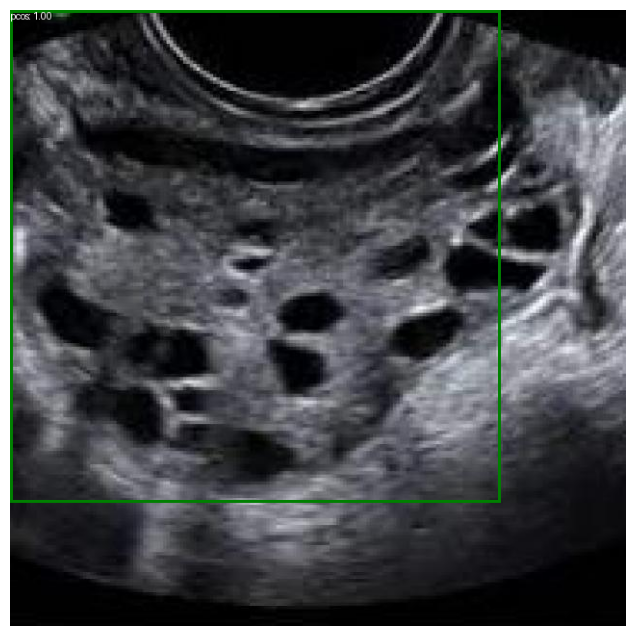

In [15]:
import torch
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont

# Define class names
class_names = ["__background__", "normal", "pcos"]

# Load image
img_path = "/content/FRCNN_pcos/train/img_0_1023_jpg.rf.4c67a6c0352ac34ddfb5b636576c8cbb.jpg"
img = Image.open(img_path).convert("RGB")

# Preprocess
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])
img_tensor = transform(img).unsqueeze(0).to(device)  # Move image to same device

# Inference
model.eval()
with torch.no_grad():
    preds = model(img_tensor)

# Draw predictions
draw = ImageDraw.Draw(img)
font = ImageFont.load_default()

for box, label, score in zip(preds[0]['boxes'], preds[0]['labels'], preds[0]['scores']):
    if score >= 0.5:  # confidence threshold
        x1, y1, x2, y2 = box.tolist()
        class_label = class_names[label] if label < len(class_names) else f"Label {label}"
        draw.rectangle([x1, y1, x2, y2], outline="green", width=3)
        draw.text((x1, max(0, y1 - 10)), f"{class_label}: {score:.2f}", fill="white", font=font)

# Show image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
img.show()

In [16]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [17]:
from torchvision.ops import box_iou
from torchvision import transforms as T
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
import numpy as np
from tqdm import tqdm


In [18]:
from torchvision import transforms

val_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [19]:
def evaluate_map(model, data_loader, device):
    model.eval()
    coco_results = []

    for batch_idx, (images, targets) in enumerate(tqdm(data_loader, desc="🔍 Running inference on validation set...")):
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i, output in enumerate(outputs):
            boxes = output["boxes"].detach().cpu().numpy()
            scores = output["scores"].detach().cpu().numpy()
            labels = output["labels"].detach().cpu().numpy()

            # ✅ Get the image_id from the dataset using index
            img_id = data_loader.dataset.ids[batch_idx * data_loader.batch_size + i]

            for box, score, label in zip(boxes, scores, labels):
                x_min, y_min, x_max, y_max = box
                coco_results.append({
                    "image_id": img_id,
                    "category_id": int(label),
                    "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
                    "score": float(score)
                })

    coco_gt = data_loader.dataset.coco
    coco_dt = coco_gt.loadRes(coco_results)

    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return {
        "mAP@50": coco_eval.stats[1],
        "mAP@50:95": coco_eval.stats[0]
    }


In [20]:
print("\n Evaluating model on validation set:")
val_map = evaluate_map(model, val_loader, device)

print(f"mAP@50: {val_map['mAP@50']:.4f}, mAP@50:95: {val_map['mAP@50:95']:.4f}")



 Evaluating model on validation set:


🔍 Running inference on validation set...: 100%|██████████| 35/35 [00:13<00:00,  2.61it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.987
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.994
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.994
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.994
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=